### Does Sentiment Analysis work ? Analysis using AFINN and Textblob on Python

Sentiment Analysis is used to sense the mood of the people based on the text they write. The text could be a tweet, review or anything whose sentiment is to be quantified. The sentiment could be positive or negative. SA(Sentiment Analysis) is difficult to validate because in many scenerios "ground truth" is not available. But in the case of Yelp Review Data, both the user review and ratings are available. Therefore rating(1 to 5) value can be used as ground truth information to validate the SA score computed. 

The data is obtained from [this link from Yelp](https://www.yelp.com/dataset_challenge). The data is downloaded and stored into a Dataframe. 

In [142]:
from textblob import TextBlob
import json
import matplotlib.pyplot as plt
%matplotlib inline  
from  matplotlib import style
import pandas as pd
from itertools import *
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [143]:
file_name = '/Users/harshkn/Documents/HobbyProjects/YelpReviewData/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json'
# json_data = open(file_name)


In [152]:
# data = pd.read_json(file_name,lines=True)
data = []
with open(file_name) as f:
    for count,line in islice(enumerate(f), 250000):
        data.append(json.loads(line))
            


#### Each entry in the file looks as shown below. It has various fields but I'll consider only 'stars' and 'text' fields.

In [209]:
data[0]

{u'business_id': u'5UmKMjUEUNdYWqANhGckJw',
 u'date': u'2012-08-01',
 u'review_id': u'Ya85v4eqdd6k9Od8HbQjyA',
 u'stars': 4,
 u'text': u'Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.',
 u'type': u'review',
 u'user_id': u'PUFPaY9KxDAcGqfsorJp3Q',
 u'votes': {u'cool': 0, u'funny': 0, u'useful': 0}}

.

In [154]:
df = pd.DataFrame(data)
FilteredDf = df[['stars', 'text']]
del df

In [155]:
# Sample entry 
print FilteredDf['text'][0]
FilteredDf.count()

Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.


stars    250000
text     250000
dtype: int64

### Using AFINN python library
AFINN is list of English words with each word assigned a positive or negative integer assigned to it in correspondence with the sentiment it carried. Following words and thier AFINN score from [AFINN repository](https://github.com/fnielsen/afinn). We can see words which carry negative sentiment are assigned negative score and vice-versa. 

 ```
await	-1  
awaited	-1  
awaits	-1  
award	3  
awarded	3  
awards	3  
awesome	4  
awful	-3  
awkward	-2  
axe	-1  
axed	-1  
backed	1  
backing	2  
backs	1  
bad	-3  
bad luck	-2
```

Sample usage of AFINN is shown below. 

In [214]:
from afinn import Afinn
afinn = Afinn()
print 'AFINN score for \'This is utterly excellent!\' is ', afinn.score('This is utterly excellent!')


AFINN score for 'This is utterly excellent!' is  3.0


NLTK stopword list is used to remove stop words from the reviews. Before this each review is tokenized into words. And then AFINN lexicon is used to assign sentiment score to each word and average sentiment score for each review is computed. 

In [221]:
#list of stop words
from nltk.corpus import stopwords 
#to tokenize a sentence into words
from nltk.tokenize import wordpunct_tokenize 
import numpy as np


# wordpunct_tokenize(FilteredDf['text'][100])

In [157]:
# To compute average sentiment score for each review
stop_words = set(stopwords.words('english'))
stop_words.update(['mr','.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # remove it if you need punctuation 
unigrams = []
afinn_value = []
stars = []
for ind,review in islice(FilteredDf.iterrows(),250000):
    unigrams = ( [i.lower() for i in wordpunct_tokenize(review['text']) if i.lower() not in stop_words])
    afinn_value.append(np.mean(list(map(lambda x: afinn.score(str(x.encode('utf-8'))), unigrams))))
    stars.append(review['stars'])

len(afinn_value)

250000

In [158]:
pro_stars = pd.DataFrame()
pro_stars['stars'] = stars
pro_stars['senti_value'] = afinn_value
pro_stars['stars'].min()

1

Later, sentiment score for each star rating is plotted as boxplot as shown below. We can see there is a some correlation between star rating and the computed average sentiment score. But we can see there is lot of variance in the box plots. This is because there are lot of words for which AFINN scores are not available and since we compute average of the total sentence, the score is normalised heavily in many cases. It can be improved by considering only words in AFINN dictionary to compute the average. 

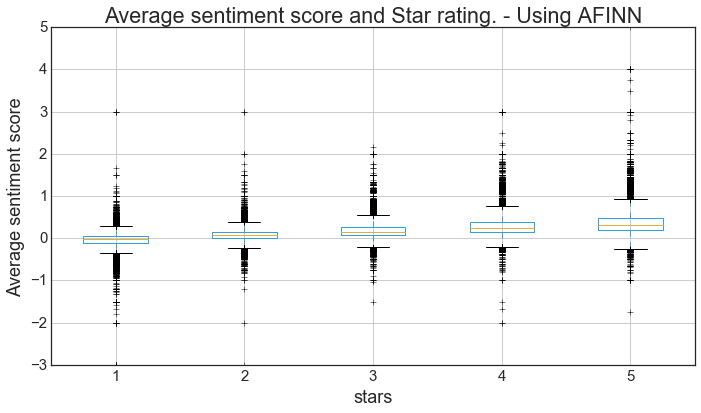

In [201]:
rcParams.update({'font.size': 15})
plt.style.use('seaborn-white')
ax = pro_stars.boxplot(by=['stars'], figsize=(10,6))
ax.get_figure().suptitle("")
ax.set_title('Average sentiment score and Star rating. - Using AFINN')
ax.set_xlabel('stars')
ax.set_ylabel('Average sentiment score')


### Using Textblob

Now, we use textblob, a text processing library which also has sentiment analysis api along with many others. Sample usage of Textblob is shown below. Later we use each review in full as an input to textblob api and compute the sentiment score. We can see from the plot below that textblob has better correlation with the star ratings than from the one obtained using AFINN. 

In [179]:
import textblob as tb

In [205]:
#Demo 
print FilteredDf['text'][0]
print FilteredDf['stars'][0]
details = TextBlob(FilteredDf['text'][0])
print
print details.sentiment
print



Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.
4

Sentiment(polarity=0.1703391053391053, subjectivity=0.3265873015873016)



In [202]:
tb_value = []
stars_tb = []
for ind,review in islice(FilteredDf.iterrows(),250000):
    details = TextBlob(review['text'])
    tb_value.append(details.sentiment.polarity)
    stars_tb.append(review['stars'])

In [203]:
pro_stars_tb = pd.DataFrame()
pro_stars_tb['stars'] = stars_tb
pro_stars_tb['senti_value'] = tb_value


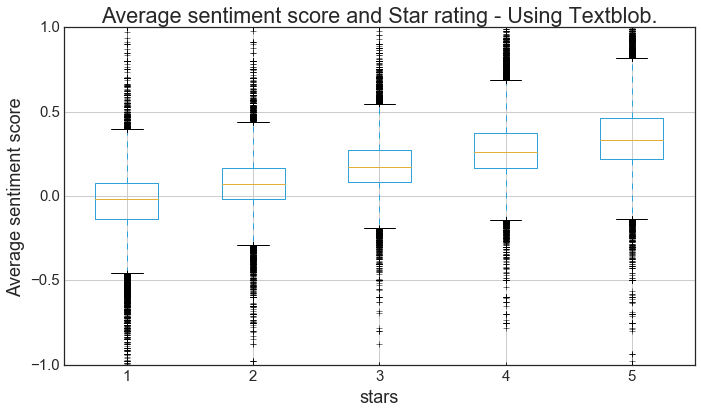

In [204]:

ax = pro_stars_tb.boxplot(by=['stars'], figsize=(10,6))
ax.get_figure().suptitle("")
ax.set_title('Average sentiment score and Star rating - Using Textblob.')
ax.set_xlabel('stars')
ax.set_ylabel('Average sentiment score')

This post is inspired by David Robinson's [post](http://varianceexplained.org/r/yelp-sentiment/) on sentiment analysis with Yelp review data. Since the post referred uses R, I wanted to try it using Python. 